In [1]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()

In [5]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

##
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model, Sequential

In [3]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [4]:
# standardise the data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std

In [7]:
def build_model():
    model = Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

In [8]:
# k fold cross validation
k = 4
num_val_samples = len(train_data) // k
n_epochs = 100
all_scores = []

for i in range(k):
    print(f"[INFO] processing fold: {i}......")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]
    ], axis=0)

    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]
    ], axis=0)

    model = build_model()
    H = model.fit(partial_train_data,
                  partial_train_targets,
                  epochs=n_epochs,
                  batch_size=16,
                  verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets)
    all_scores.append(val_mae)

[INFO] processing fold: 0......
101/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [9]:
all_scores

[1.8881413, 2.4668384, 2.4461758, 2.4478312]

In [10]:
np.mean(all_scores)

2.3122466

In [12]:
n_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f"[INFO] processing fold: {i}......")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([
        train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]
    ], axis=0)

    partial_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]
    ], axis=0)

    model = build_model()
    H = model.fit(partial_train_data,
                  partial_train_targets,
                  validation_data=(val_data, val_targets),
                  epochs=n_epochs,
                  batch_size=16,
                  verbose=0)
    mae_history = H.history["val_mae"]
    all_mae_histories.append(mae_history)

[INFO] processing fold: 0......
[INFO] processing fold: 1......
[INFO] processing fold: 2......
[INFO] processing fold: 3......


In [20]:
# calculate per apoch avg val_mae
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]

In [21]:
average_mae_history

[18.888685,
 15.113352,
 10.764713,
 7.2720933,
 5.5639215,
 4.604599,
 3.9591296,
 3.5863297,
 3.34866,
 3.2694504,
 3.1061072,
 2.9830692,
 2.9559064,
 2.8504972,
 2.7754924,
 2.6928105,
 2.6761482,
 2.6826408,
 2.6302886,
 2.607111,
 2.5412893,
 2.6302397,
 2.567249,
 2.523388,
 2.5532432,
 2.514974,
 2.4895432,
 2.538257,
 2.5017302,
 2.5014465,
 2.547789,
 2.5077572,
 2.4497733,
 2.4782467,
 2.423761,
 2.4226928,
 2.4855015,
 2.4108438,
 2.4224381,
 2.40919,
 2.3966594,
 2.4194736,
 2.434154,
 2.410677,
 2.3896892,
 2.37591,
 2.379013,
 2.4018817,
 2.4586015,
 2.4049335,
 2.3797133,
 2.4552069,
 2.3866644,
 2.42883,
 2.338664,
 2.338007,
 2.3797338,
 2.3483884,
 2.3992505,
 2.4114707,
 2.3392854,
 2.3622987,
 2.3152199,
 2.333594,
 2.3923898,
 2.372518,
 2.3482997,
 2.3430405,
 2.317306,
 2.3074563,
 2.3568923,
 2.3435974,
 2.3234606,
 2.3225996,
 2.3235264,
 2.3414912,
 2.328869,
 2.3358974,
 2.3194463,
 2.3234353,
 2.313608,
 2.2838771,
 2.3604658,
 2.312362,
 2.2812076,
 2.3055

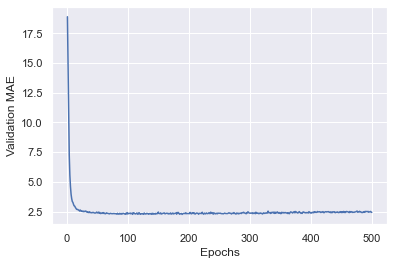

In [22]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()